# SCC.413 Applied Data Mining
# Final Project

In [2]:
import _locale
import random
import pickle
import linecache
from bs4 import BeautifulSoup
import sys
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import ftfy
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer

Configuration

In [97]:
## Configuration

_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.options.display.max_colwidth = 300

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaoulis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kaoulis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Preparing Sentiment140 dataset
## Important Note
Unfortunately, this dataset size is very big and I cannot upload it in module. I provide the download link and please save the training.1600000.processed.noemoticon.csv file in the Sentiment140 folder.
https://www.kaggle.com/kazanova/sentiment140

In [4]:
##
# Prepare data sets
df = pd.read_csv('Sentiment140/training.1600000.processed.noemoticon.csv',
                 header=None,
                 names=['sentiment', 'ids', 'date', 'flag', 'user', 'text'],
                 encoding='ISO-8859–1')  # ISO-8859–1 or latin-1?
df = df.drop(['ids', 'date', 'flag', 'user'], 1)
df.sentiment = df.sentiment.replace({0: 0, 4: 1})
print(df.sentiment.value_counts())

##
df_positive = df[df['sentiment'] == 1]
df_negative = df[df['sentiment'] == 0]

df_positive = df_positive.drop('sentiment', 1)
df_negative = df_negative.drop('sentiment', 1)

##
df_positive.to_csv('Sentiment140/positive140.csv', encoding='utf-8', index=False, header=False)
df_negative.to_csv('Sentiment140/negative140.csv', encoding='utf-8', index=False, header=False)

1    800000
0    800000
Name: sentiment, dtype: int64


## Classes and Methods

A couple of methods for showing classifier results (Evaluation Part):

In [24]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean() * 100,
                                                                                scores.std() * 100, scores.min() * 100,
                                                                                scores.max() * 100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index=index, columns=index)
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index=index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0) * 100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

Our Document class and associated functions for processing text.

In [25]:
def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items
fws = read_list("functionwords.txt")

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
nonASCII_re = re.compile(r'[^\x00-\x7F]+')
letters_re = re.compile(r"([^a-zA-Z])")
whitespaces_re = re.compile(r"\s+")


def preprocess(text):
    soup = BeautifulSoup(text, 'lxml')
    p_text = soup.get_text()
    p_text = hashtag_re.sub(" ", p_text)
    p_text = mention_re.sub(" ", p_text)
    p_text = url_re.sub(" ", p_text)
    p_text = nonASCII_re.sub(" ", p_text)
    p_text = ftfy.fix_text(p_text)
    p_text = letters_re.sub(" ", p_text)
    p_text = whitespaces_re.sub(" ", p_text).strip()
    return p_text.lower()


tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)")  # ([]|words|other non-space)


def tokenise(text):
    return tokenise_re.findall(text)


class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter()  # empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = []  # empty list for pos tags from running text.
        self.num_tokens = 0
        self.text = ""

    def extract_features_from_text(self, text):
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens)  # updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_textV2(self, text):
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = []
        for t in tokens:
            if t in fws:
                continue
            else:
                lower_tokens.append(t.lower())
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens)  # updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)

    def extract_features_from_texts(self, texts):  # texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            self.extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

In [26]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [27]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    hapaxes = list(document.tokens_fql.values()).count(1) #convert frequencies to list and count 1s.
    hapax_ratio = hapaxes / len(document.tokens_fql)
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr, 'hr': hapax_ratio}

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

In [28]:
lexn = read_list("opinion-lexicon-English/negative-words-utf8.txt")
lexp = read_list("opinion-lexicon-English/positive-words-utf8.txt")


def get_positive_fql(document):
    pos_fql = Counter({t: document.tokens_fql[t] for t in lexp})  # dict comprehension, t: fql[t] is token: freq.
    return +pos_fql

def get_negative_fql(document):
    neg_fql = Counter({t: document.tokens_fql[t] for t in lexn})  # dict comprehension, t: fql[t] is token: freq.
    return +neg_fql

def get_nothing(document):
    return {'asdf': 1}

In [29]:
def import_tweets_docs(file, label):
    metadata = {'label': label}
    with open(file) as f:
        tweets = f.readlines()
        i = 0
        for tweet in tweets:
            if (i + 1) % (round(len(tweets) / 100)) == 0:
                print("Completed ", int(((i + 1) / len(tweets)) * 100), "%")
            doc = Document(meta=metadata)
#             with fuctionwords:
            doc.extract_features_from_text(tweet)
#             without fuctionwords:
#             doc.extract_features_from_textV2(tweet)
            if doc.num_tokens == 0:
                i += 1
                continue
            i += 1
            yield doc

In [105]:
def import_dev_corpus(file, label):
    random.seed(30)
    metadata = {'label': label}
    idxs = random.sample(range(800000), 8000)
    tweets = [linecache.getline(file, i) for i in idxs]
    i = 0
    for tweet in tweets:
        if (i + 1) % (len(tweets) / 100) == 0:
            print("Completed ", int(((i + 1) / len(tweets)) * 100), "%")
            sys.stdout.write("\033[F")
        doc = Document(meta=metadata)
#         with functionwords:
        doc.extract_features_from_text(tweet)
#         without functionwords:
#         doc.extract_features_from_textV2(tweet)
        if doc.num_tokens == 0:
            i += 1
            continue
        i += 1
        yield doc

## Model Building (Development)

Initially, we create a development corpus for hyper-parameter tuning

In [106]:
dev_corpus = []
print('Import Negative')
dev_corpus.extend(import_dev_corpus("Sentiment140/negative140.csv", "negative"))
print('Import Positive')
dev_corpus.extend(import_dev_corpus("Sentiment140/positive140.csv", "positive"))

Import Negative
Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  28 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  56 %
Completed  57 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
C

In [107]:
y = [d.meta['label'] for d in dev_corpus]
X = dev_corpus

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

12765 3192
12765 3192


The pipeline with feature union implemented on POS tags, token words, word statistics and lexicons. 

In [68]:
## The pipeline
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method=get_tokens_fql)),  # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method=None)), # get_pos_fql
                ('vectorizer', DictVectorizer()),
            ])),
            ('poslex', Pipeline([
                ('processor', DocumentProcessor(process_method=None)), # get_positive_fql
                ('vectorizer', DictVectorizer()),
            ])),
            ('neglex', Pipeline([
                ('processor', DocumentProcessor(process_method=None)), # get_negative_fql
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # get_text_stats
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func=chi2)),
    ('scaler', TfidfTransformer(norm=None)),
    ('clf', None),  # to be set by grid search.
])

Fitting the model with logistic regression and Naive Bayes. Validated by 5-fold stratified cross validation. Feature selection with chi2 test.

In [69]:
param_grid = {
    'union__pos__processor__process_method': [get_nothing, get_pos_fql],
    'union__poslex__processor__process_method': [get_nothing, get_positive_fql],
    'union__neglex__processor__process_method': [get_nothing, get_negative_fql],
    'union__stats__processor__process_method': [get_nothing, get_text_stats],
    'selector': [None, SelectKBest(score_func=chi2, k=500), SelectKBest(score_func=chi2, k=700), SelectKBest(score_func=chi2, k=900)],
    'clf': [LogisticRegression(solver='liblinear', random_state=0), MultinomialNB()],
}
search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
                      return_train_score=False,
                      scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit='f1_weighted',
                      param_grid=param_grid
                      )

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('word', Pipeline(memory=None,
     steps=[('processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x00000249F087FD08>)), ('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
    ...er', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False, use_idf=True)), ('clf', None)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'union__pos__processor__process_method': [<function get_nothing at 0x00000249F574E840>, <function get_pos_fql at 0x00000249F07CED08>], 'union__poslex__processor__process_method': [<function get_nothing at 0x00000249F574E840>, <function get_positive_fql at 0x00000249F087FF28>], 'union__ne...l=0.0001, verbose=0, warm_start=False), MultinomialNB(alpha=1.0, class_prior

Evaluation

In [70]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_f1_weighted')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_selector,param_union__neglex__processor__process_method,param_union__pos__processor__process_method,param_union__poslex__processor__process_method,param_union__stats__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_test_recall_weighted,split1_test_recall_weighted,split2_test_recall_weighted,split3_test_recall_weighted,split4_test_recall_weighted,mean_test_recall_weighted,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
28,24.218471,1.062234,24.808035,2.173537,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=0, solver='liblinear',\n tol=0.0001, verbose=0, warm_start=False)","SelectKBest(k=500, score_func=<function chi2 at 0x00000249ED9DB598>)",<function get_negative_fql at 0x00000249F59E0D90>,<function get_pos_fql at 0x00000249F07CED08>,<function get_nothing at 0x00000249F574E840>,<function get_nothing at 0x00000249F574E840>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'selector': SelectKBe...",0.734534,0.755190,0.745006,0.753623,0.734326,0.744536,0.008951,1,0.736643,0.755998,0.748065,0.755950,0.735460,0.746423,0.008955,1,0.734534,0.755190,0.745006,0.753623,0.734326,0.744536,0.008951,1,0.733957,0.755009,0.744242,0.753082,0.734017,0.744061,0.008992,1
30,35.942201,3.134861,34.933741,3.058347,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=0, solver='liblinear',\n tol=0.0001, verbose=0, warm_start=False)","SelectKBest(k=500, score_func=<function chi2 at 0x00000249ED9DB598>)",<function get_negative_fql at 0x00000249F59E0D90>,<function get_pos_fql at 0x00000249F07CED08>,<function get_positive_fql at 0x00000249F087FF28>,<function get_nothing at 0x00000249F574E840>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'selector': SelectKBe...",0.732968,0.759499,0.745789,0.751273,0.732759,0.744458,0.010424,2,0.734858,0.760439,0.748771,0.753656,0.733885,0.746322,0.010442,2,0.732968,0.759499,0.745789,0.751273,0.732759,0.744458,0.010424,2,0.732444,0.759294,0.745050,0.750709,0.732448,0.743989,0.010459,2
29,30.408849,0.565180,30.748932,2.042919,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=0, solver='liblinear',\n tol=0.0001, verbose=0, warm_start=False)","SelectKBest(k=500, score_func=<function chi2 at 0x00000249ED9DB598>)",<function get_negative_fql at 0x00000249F59E0D90>,<function get_pos_fql at 0x00000249F07CED08>,<function get_nothing at 0x00000249F574E840>,<function get_text_stats at 0x00000249F07CEF28>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0,

In [109]:
predictions = search.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Accuracy:  0.7728696741854637
              precision    recall  f1-score   support

    negative       0.79      0.74      0.76      1598
    positive       0.75      0.81      0.78      1594

   micro avg       0.77      0.77      0.77      3192
   macro avg       0.77      0.77      0.77      3192
weighted avg       0.77      0.77      0.77      3192

[[1177  421]
 [ 304 1290]]


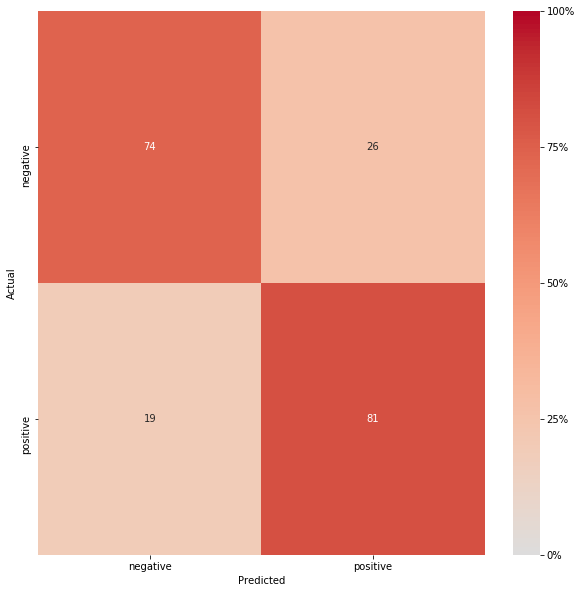

In [110]:
confusion_matrix_percent_heatmap(confusion_matrix(y_test, predictions), search.classes_)

## Model Building (Training)

In [184]:
corpus = []
print('Import Negative')
corpus.extend(import_tweets_docs("Sentiment140/negative140.csv", "negative"))
print('Import Positive')
corpus.extend(import_tweets_docs("Sentiment140/positive140.csv", "positive"))

y = [d.meta['label'] for d in corpus]
X = corpus

Import Negative
Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  28 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  56 %
Completed  57 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
C

In [185]:
final_model1 = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method=get_tokens_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method=get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('neglex', Pipeline([
                ('processor', DocumentProcessor(process_method=get_negative_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func=chi2, k=500)),
    ('scaler', TfidfTransformer(norm=None)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])
final_model1.fit(X, y)

final_model2 = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method=get_tokens_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('neglex', Pipeline([
                ('processor', DocumentProcessor(process_method=get_negative_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func=chi2, k=500)),
    ('scaler', TfidfTransformer(norm=None)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])
final_model2.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('word', Pipeline(memory=None,
     steps=[('processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x0000020E038C7730>)), ('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
    ...nalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

Saving the models.

In [189]:
with open('final_model1.pkl', 'wb') as f:
    pickle.dump(final_model1, f)
with open('final_model2.pkl', 'wb') as f:
    pickle.dump(final_model2, f)

Loading the models.

In [65]:
with open('final_model1.pkl', 'rb') as f:
    final_model1 = pickle.load(f)
with open('final_model2.pkl', 'rb') as f:
    final_model2 = pickle.load(f)

## Information Retrieval  
This code was run in Pycharm for better debugging. It needs to be run for each month we are interested for. Of course, it could be develloped to be run once, but it was unnecessary for the proposes of this project. The configuration parameters are last_day which indicates the last day of the month and the month.

In [3]:
import time
import GetOldTweets3 as got
from langdetect import detect

################## Configuration parameters
month = 5
last_day = 21
###########################################


data = []
from_date = 1
to_date = 2

while True:
    print('day ', from_date)
    flag = True
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('#borisjohnson') \
        .setSince("2020-"+ str(month)+"-" + str(from_date)) \
        .setUntil("2020-"+ str(month)+"-" + str(to_date)) \
        .setMaxTweets(5000)
    try:
        tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    except:
        print("Time to sleep")
        time.sleep(600)
        print("Good Morning!")
        flag = False
    if flag:
        for twt in tweets:
            try:
                if detect(twt.text) != 'en':
                    continue
                data.append([twt.date.day, twt.date.month, twt.text])
            except:
                continue
        from_date += 1
        to_date += 1
        if to_date == last_day:
            break

df = pd.DataFrame(data, columns=["day", "month", "text"])
df.to_csv('retrieved-tweets\Maytest.csv', encoding='utf-8', index=False, header=False)

day  1


Now, we have to concatenate March, April and May data sets in one data set.

In [4]:
df_March = pd.read_csv('retrieved-tweets\March.csv',
                 header=None,
                 names=['day', 'month', 'text'],
                 encoding='utf-8')
df_April = pd.read_csv('retrieved-tweets\April.csv',
                 header=None,
                 names=['day', 'month', 'text'],
                 encoding='utf-8')
df_May = pd.read_csv('retrieved-tweets\May.csv',
                 header=None,
                 names=['day', 'month', 'text'],
                 encoding='utf-8')

df_tweets = pd.concat([df_March, df_April, df_May])
df_tweets.to_csv('tweets.csv', encoding='utf-8', index=False, header=False)

Let's check how tweets are distributed over the months.

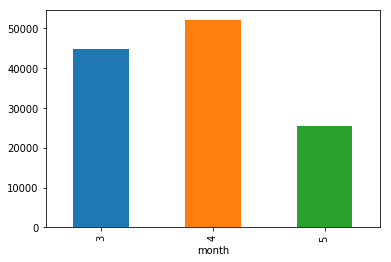

In [5]:
df_tweets_grp = df_tweets.groupby(['month'])
df_tweets_grp.size().plot.bar()

Now, we use the Afinn lexicon to measure the polarity score and therefore remove objective tweets(polarity=0).

In [6]:
from afinn import Afinn

af = Afinn()
df_tweets['polarity'] = [af.score(text) for text in df_tweets['text']]

In [100]:
df_sub_tweets = df_tweets[df_tweets.polarity != 0]

Text(0.5, 0, 'Month')

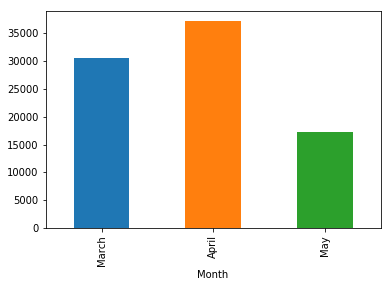

In [101]:
df_sub_tweets_grp = df_sub_tweets.groupby(['month'])
df_sub_tweets_grp.size().plot.bar()
plt.xticks(range(3), ['March','April','May'])
plt.xlabel('Month')

Let's check how tweets are distributed over the full period.

([<matplotlib.axis.XTick at 0x1cd27fb5208>,
 <a list of 38 Text xticklabel objects>)

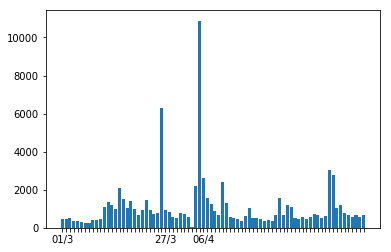

In [102]:
df_sub_tweets_grp2 = df_sub_tweets.groupby(['month','day'])
x1 = list(df_sub_tweets_grp2.groups.keys())
y1 = df_sub_tweets.groupby(['month','day']).size().tolist()
x1 = [str(j) for j in x1]
plt.bar(x1, y1)
tickPos = [i for i in range(80)]
ticks = []
ticks.append("01/3")
for i in range(26):
    ticks.append("")
ticks.append("27/3")
for i in range(9):
    ticks.append("")
ticks.append("06/4")
plt.xticks(tickPos, ticks)

## Prediction and Error Analysis

Now, we can classify the retrieved tweets with our model.

In [103]:
def import_analysis_docs(df):
    tweets = [text for text in df['text']]
    i = 0
    for tweet in tweets:
        if (i + 1) % (round(len(tweets) / 100)) == 0:
            print("Completed ", int(((i + 1) / len(tweets)) * 100), "%")
        doc = Document()
        doc.extract_features_from_text(tweet)
#         doc.extract_features_from_textV2(tweet)
        i += 1
        yield doc

In [111]:
analysis_corpus = []
analysis_corpus.extend(import_analysis_docs(df_sub_tweets))

predictions = final_model1.predict(analysis_corpus)
df_sub_tweets['model1'] = predictions
predictions = final_model2.predict(analysis_corpus)
df_sub_tweets['model2'] = predictions

Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  29 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  57 %
Completed  58 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
Completed  63 %
C

D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Manually, we check how the two models operate.

In [98]:
df_sub_tweets[df_sub_tweets['model1'] != df_sub_tweets['model2']].sample(5, random_state=3)[['text','model1','model2']]

,text,model1,model2
7719,So as well all expected #BorisJohnson #BorisTheLiar and the #Conservatives have to decided to save the economy And not people - and get rid of the non-economically productive (that’s old and disabled to you and me),positive,negative
31478,"The oil price cut and shorting of the markets have benefited billionaires and traders like Robert Mercer - the scumbag behind #Trump, #Farage, #BorisJohnson #FiveStar #LePen https://en.wikipedia.org/wiki/Robert_Mercer",positive,negative
74991,"That was a very long-winded way of ordering the working class to ""take it on the chin"" and put their lives at risk. Appalling. #BorisJohnson #BorisHasFailed #BorisSpeech",positive,negative
27015,So now #BorisJohnson has also tested positive for #CoronavirusPandemic,negative,positive
76811,I don't have anything nice to say so I'll say nothing #BorisJohnson,negative,positive


And we keep model2.

In [112]:
df_sub_tweets['label'] = predictions
df_sub_tweets = df_sub_tweets.drop(['model1', 'model2'], 1)

D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


If we check the ratio between negative and positive with model2, we observe that negative are slighty more than positive tweets. However, this is rational because our training set did not consist of neutral.

In [52]:
import numpy as np
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{'negative': 43004, 'positive': 41951}

## Analysis
Initially, we create some columns that are used for the analysis part. That is, the daily total, the number of negative and positive tweets the negative positive ratio and the daily polarity scores. Then we save the dataframe to create a ckeckpoint.

In [211]:
df_sub_tweets['total'] = df_sub_tweets.groupby(['month', 'day'])['text'].transform('size')
df_sub_tweets['daily_sentiment'] = df_sub_tweets.groupby(['month', 'day', 'label'])['text'].transform('size')
df_sub_tweets['daily_polarity'] = df_sub_tweets.groupby(['month', 'day'])['polarity'].transform('sum')
df_sub_tweets['daily_ratio'] = df_sub_tweets['daily_sentiment'] / df_sub_tweets['total']
df_sub_tweets.to_csv('sub_tweets.csv', encoding='utf-8', index=False, header=False)

D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Users\Kaoulis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [53]:
df_sub_tweets = pd.read_csv('sub_tweets.csv',
                 header=None,
                 names=['day','month','text','polarity','label','total','daily_sentiment','daily_polarity','daily_ratio'],
                 encoding='utf-8')  # ISO-8859–1 or latin-1?

We gather our statistics in a final dataframe which also contains the daily new cases and deaths of Coronavirus.

In [54]:
df_analytica = df_sub_tweets[df_sub_tweets.label == 'negative']
df_analytica = df_analytica.drop(['text', 'polarity', 'label'], 1).drop_duplicates().reset_index(drop=True)
covid = pd.read_csv("owid-covid-data.csv", usecols=['new_cases','new_deaths'])
df_analytica = df_analytica.join(covid)

In [55]:
df_analytica

,day,month,total,daily_sentiment,daily_polarity,daily_ratio,new_cases,new_deaths
0,1,3,454,220,-138.0,0.484581,5,0
1,2,3,441,204,-312.0,0.462585,13,0
2,3,3,501,216,-462.0,0.431138,4,0
3,4,3,357,175,-540.0,0.490196,11,0
4,5,3,371,197,-685.0,0.530997,34,0
5,6,3,299,143,-496.0,0.478261,30,0
6,7,3,234,122,-330.0,0.521368,48,1
7,8,3,249,124,-216.0,0.497992,43,1
8,9,3,398,201,-365.0,0.505025,67,0
9,10,3,403,201,-353.0,0.498759,48,1


Pearson correlation to answer the research question.

In [64]:
corr = df_analytica[['daily_ratio','daily_polarity','new_cases','new_deaths']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,daily_ratio,daily_polarity,new_cases,new_deaths
daily_ratio,1,-0.38,0.16,0.11
daily_polarity,-0.38,1,0.25,0.2
new_cases,0.16,0.25,1,0.84
new_deaths,0.11,0.2,0.84,1


Visual sentiment analysis over the pandemic period.

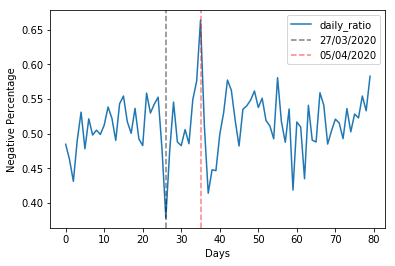

In [8]:
df_analytica['daily_ratio'].plot.line()
plt.axvline(x=26, color='k', linestyle='--', alpha=0.5, label='27/03/2020')
plt.axvline(x=35, color='r', linestyle='--', alpha=0.5, label='05/04/2020')
plt.xlabel('Days')
plt.ylabel('Negative Percentage')
plt.legend()

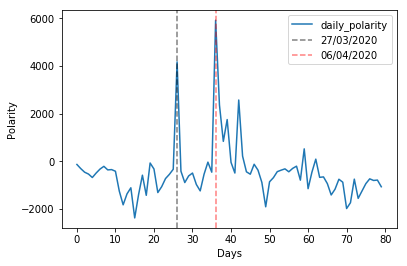

In [9]:
df_analytica['daily_polarity'].plot.line()
plt.axvline(x=26, color='k', linestyle='--', alpha=0.5, label='27/03/2020')
plt.axvline(x=36, color='r', linestyle='--', alpha=0.5, label='06/04/2020')
plt.xlabel('Days')
plt.ylabel('Polarity')
plt.legend()

Text(0, 0.5, 'New cases')

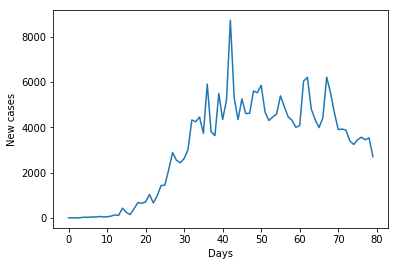

In [11]:
plt.plot(df_analytica['new_cases'])
plt.xlabel('Days')
plt.ylabel('New cases')

Finally, we could measure the emotional frequencies of these special dates with NRC lexicon.

In [102]:
from nrclex import NRCLex
full_text = ''
text_object = NRCLex("")
i = 0
for text in df_sub_tweets['text'][df_sub_tweets.month == 3][df_sub_tweets.day == 27]:
    if (i + 1) % (round(len(df_sub_tweets['text'][df_sub_tweets.month == 3][df_sub_tweets.day == 27]) / 100)) == 0:
        print("Completed ", int(((i + 1) / len(df_sub_tweets['text'][df_sub_tweets.month == 4][df_sub_tweets.day == 5])) * 100), "%")
    full_text += str(text)
    i += 1
text_object.append_text(full_text)

Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  29 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  57 %
Completed  58 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
Completed  63 %
C

In [103]:
first = pd.DataFrame([text_object.affect_frequencies]).transpose()
first['date'] = '27/3'
first

,0,date
anger,0.096376,27/3
anticip,0.094974,27/3
disgust,0.093428,27/3
fear,0.099834,27/3
joy,0.095408,27/3
negative,0.111669,27/3
positive,0.113658,27/3
sadness,0.098796,27/3
surprise,0.089171,27/3
trust,0.106687,27/3


In [104]:
full_text = ''
text_object = NRCLex("")
i = 0
for text in df_sub_tweets['text'][df_sub_tweets.month == 4][df_sub_tweets.day == 5]:
    if (i + 1) % (round(len(df_sub_tweets['text'][df_sub_tweets.month == 4][df_sub_tweets.day == 5]) / 100)) == 0:
        print("Completed ", int(((i + 1) / len(df_sub_tweets['text'][df_sub_tweets.month == 4][df_sub_tweets.day == 5])) * 100), "%")
    full_text += str(text)
    i += 1
text_object.append_text(full_text)

Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  29 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  57 %
Completed  58 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
Completed  63 %
C

In [105]:
second = pd.DataFrame([text_object.affect_frequencies]).transpose()
second['date'] = '05/4'
second

,0,date
anger,0.095526,05/4
anticip,0.092771,05/4
disgust,0.090363,05/4
fear,0.104779,05/4
joy,0.091328,05/4
negative,0.109925,05/4
positive,0.117018,05/4
sadness,0.103674,05/4
surprise,0.087477,05/4
trust,0.107138,05/4


In [106]:
full_text = ''
text_object = NRCLex("")
i = 0
for text in df_sub_tweets['text']:
    if (i + 1) % (round(len(df_sub_tweets['text']) / 100)) == 0:
        print("Completed ", int(((i + 1) / len(df_sub_tweets['text'])) * 100), "%")
    full_text += str(text)
    i += 1
text_object.append_text(full_text)

Completed  1 %
Completed  2 %
Completed  3 %
Completed  4 %
Completed  5 %
Completed  6 %
Completed  7 %
Completed  8 %
Completed  9 %
Completed  10 %
Completed  11 %
Completed  12 %
Completed  13 %
Completed  14 %
Completed  15 %
Completed  16 %
Completed  17 %
Completed  18 %
Completed  19 %
Completed  20 %
Completed  21 %
Completed  22 %
Completed  23 %
Completed  24 %
Completed  25 %
Completed  26 %
Completed  27 %
Completed  28 %
Completed  29 %
Completed  30 %
Completed  31 %
Completed  32 %
Completed  33 %
Completed  34 %
Completed  35 %
Completed  36 %
Completed  37 %
Completed  38 %
Completed  39 %
Completed  40 %
Completed  41 %
Completed  42 %
Completed  43 %
Completed  44 %
Completed  45 %
Completed  46 %
Completed  47 %
Completed  48 %
Completed  49 %
Completed  50 %
Completed  51 %
Completed  52 %
Completed  53 %
Completed  54 %
Completed  55 %
Completed  56 %
Completed  57 %
Completed  58 %
Completed  59 %
Completed  60 %
Completed  61 %
Completed  62 %
Completed  63 %
C

In [107]:
full = pd.DataFrame([text_object.affect_frequencies]).transpose()
full['date'] = 'full period'
full

,0,date
anger,0.096871,full period
anticip,0.094542,full period
disgust,0.093411,full period
fear,0.100054,full period
joy,0.094508,full period
negative,0.111259,full period
positive,0.113575,full period
sadness,0.098818,full period
surprise,0.090089,full period
trust,0.106873,full period


Finally, we concat the above dataframes and we visualise the results.

In [108]:
alll = pd.concat([first,second,full]).drop(['negative', 'positive'], axis=0)
alll.reset_index(level=0, inplace=True)
alll.columns = ['emotion' ,'freq', 'date']

<Figure size 1332x756 with 0 Axes>

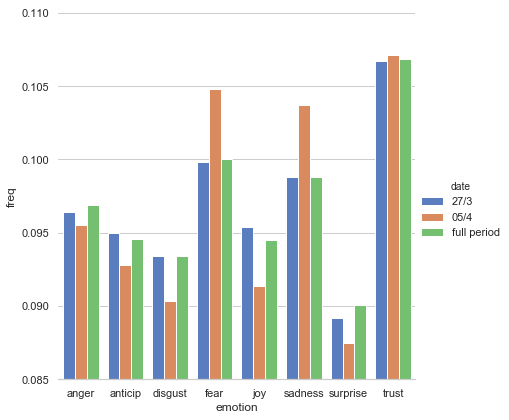

In [131]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.set(style="whitegrid")
g = sns.catplot(x="emotion", y="freq", hue="date", data=alll,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
plt.ylim(0.085, 0.11)
fig.savefig('test2png.png', dpi=100)

## Clouds
Full period

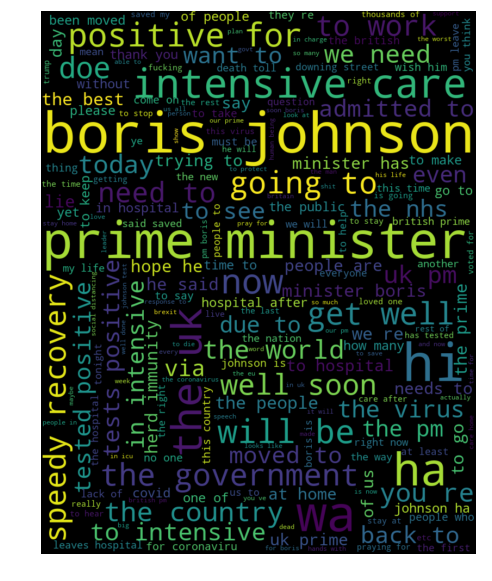

In [137]:
string = []
for t in df_sub_tweets['text']:
    string.append(preprocess(t))
string = pd.Series(string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=1000, max_font_size=200).generate(string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

27/03/2020

In [150]:
tokens_fql = Counter()
fws = read_list("functionwords.txt")
for text in df_sub_tweets['text'][df_sub_tweets['day']==27][df_sub_tweets['month']==3]:
    p_text = preprocess(text)
    tokens = tokenise(p_text)
    lower_tokens = []
    for t in tokens:
        if t in fws:
            continue
        else:
            lower_tokens.append(t.lower())
    tokens_fql.update(lower_tokens)
tokens_fql.most_common()

[('positive', 2154),
 ('boris', 1475),
 ('johnson', 1141),
 ('tested', 1081),
 ('tests', 1054),
 ('minister', 975),
 ('prime', 964),
 ('coronavirus', 825),
 ('uk', 784),
 ('pm', 698),
 ('people', 517),
 ('virus', 455),
 ('well', 447),
 ('british', 379),
 ('covid', 376),
 ('self', 271),
 ('symptoms', 268),
 ('hands', 265),
 ('hope', 258),
 ('corona', 258),
 ('soon', 257),
 ('news', 245),
 ('mild', 245),
 ('don', 244),
 ('test', 244),
 ('do', 224),
 ('m', 214),
 ('country', 210),
 ('got', 208),
 ('recovery', 204),
 ('wish', 199),
 ('breaking', 194),
 ('please', 186),
 ('re', 180),
 ('think', 175),
 ('why', 174),
 ('said', 174),
 ('there', 171),
 ('take', 169),
 ('stay', 166),
 ('government', 165),
 ('world', 162),
 ('health', 162),
 ('infected', 160),
 ('only', 157),
 ('nhs', 156),
 ('testing', 150),
 ('home', 147),
 ('speedy', 147),
 ('see', 146),
 ('know', 146),
 ('doing', 142),
 ('isolating', 142),
 ('still', 134),
 ('even', 132),
 ('best', 132),
 ('did', 131),
 ('too', 128),
 ('let',

05/04/2020

In [153]:
tokens_fql = Counter()
fws = read_list("functionwords.txt")
for text in df_sub_tweets['text'][df_sub_tweets['day']==5][df_sub_tweets['month']==4]:
    p_text = preprocess(text)
    tokens = tokenise(p_text)
    lower_tokens = []
    for t in tokens:
        if t in fws:
            continue
        else:
            lower_tokens.append(t.lower())
    tokens_fql.update(lower_tokens)
tokens_fql.most_common()

[('hospital', 669),
 ('admitted', 502),
 ('boris', 497),
 ('well', 314),
 ('hope', 291),
 ('johnson', 290),
 ('recovery', 264),
 ('pm', 252),
 ('prime', 245),
 ('minister', 240),
 ('soon', 236),
 ('symptoms', 219),
 ('speedy', 196),
 ('wish', 194),
 ('people', 190),
 ('coronavirus', 183),
 ('virus', 166),
 ('tests', 152),
 ('wishing', 148),
 ('days', 145),
 ('uk', 122),
 ('don', 120),
 ('do', 117),
 ('news', 114),
 ('best', 110),
 ('m', 101),
 ('positive', 100),
 ('country', 95),
 ('please', 89),
 ('ill', 80),
 ('re', 76),
 ('testing', 76),
 ('there', 75),
 ('think', 70),
 ('very', 67),
 ('politics', 67),
 ('only', 65),
 ('why', 65),
 ('going', 63),
 ('political', 63),
 ('take', 62),
 ('nhs', 61),
 ('full', 61),
 ('really', 60),
 ('stay', 58),
 ('human', 57),
 ('wishes', 57),
 ('hospitalized', 56),
 ('never', 56),
 ('back', 55),
 ('gets', 55),
 ('taken', 55),
 ('breaking', 54),
 ('let', 53),
 ('still', 53),
 ('government', 52),
 ('health', 52),
 ('covid', 51),
 ('said', 50),
 ('british

06/04/2020

In [14]:
tokens_fql = Counter()
fws = read_list("functionwords.txt")
for text in df_sub_tweets['text'][df_sub_tweets['day']==6][df_sub_tweets['month']==4]:
    p_text = preprocess(text)
    tokens = tokenise(p_text)
    lower_tokens = []
    for t in tokens:
        if t in fws:
            continue
        else:
            lower_tokens.append(t.lower())
    tokens_fql.update(lower_tokens)
tokens_fql.most_common()

[('boris', 2959),
 ('care', 2166),
 ('intensive', 1941),
 ('well', 1639),
 ('recovery', 1618),
 ('prime', 1539),
 ('minister', 1527),
 ('johnson', 1408),
 ('soon', 1353),
 ('hope', 1324),
 ('speedy', 1120),
 ('pm', 1105),
 ('wish', 1040),
 ('moved', 1021),
 ('wishing', 853),
 ('people', 852),
 ('hospital', 839),
 ('symptoms', 753),
 ('best', 703),
 ('uk', 675),
 ('country', 633),
 ('don', 584),
 ('news', 569),
 ('family', 561),
 ('politics', 545),
 ('political', 544),
 ('prayers', 539),
 ('do', 527),
 ('virus', 526),
 ('icu', 510),
 ('coronavirus', 507),
 ('come', 505),
 ('admitted', 496),
 ('please', 491),
 ('thoughts', 476),
 ('pray', 474),
 ('very', 461),
 ('praying', 443),
 ('man', 432),
 ('human', 429),
 ('re', 428),
 ('m', 423),
 ('really', 410),
 ('stay', 410),
 ('wishes', 395),
 ('there', 375),
 ('fight', 366),
 ('full', 364),
 ('british', 363),
 ('think', 358),
 ('taken', 348),
 ('needs', 344),
 ('let', 338),
 ('health', 332),
 ('condition', 329),
 ('strong', 321),
 ('back', 3